In [1]:
import construction as cs
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


import dynamic_metrics as ds


import matplotlib.pyplot as plt

### read font
from matplotlib import font_manager

font_dirs = ['Barlow/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Barlow'

import networkx as nx
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




%load_ext autoreload
%autoreload 2

In [2]:
import os 

# load distributions coverage

k volte, con n0 e t0 random

In [3]:

ORIGINAL_COLOR = '#474747' #dark grey
ETN_COLOR =  '#fb7041' #'#E5865E' # arancio
TAG_COLOR = '#96ccc8' # light blue
STM_COLOR = '#bad1f2' #8F2E27' # rosso
DYM_COLOR = '#559ca6' # teal



line_width = 1.5


In [10]:
def compute_counts(ro,e):
    counts = []
    e = np.array(e)
    for i in range(len(ro)-1):
        r1 = ro[i]
        r2 = ro[i+1]
        ee = e[e>r1]
        count = ee[ee<=r2]
        counts.append(len(count))
    return counts

def compute_multpile_counts(ranges,ee):
    counts = []
    for e in ee:
        counts.append(compute_counts(ranges,e))
    return counts



# example of calculating the kl divergence between two mass functions
from math import log2
 
# calculate the kl divergence
def kl_divergence_max(d2, d1):
    
    max_len = max(len(d1),len(d2))

    new_d1 = np.zeros(max_len)
    new_d1[:len(d1)] = d1

    new_d2 = np.zeros(max_len)
    new_d2[:len(d2)] = d2
    
    E = 0.0000001
    new_d1 = new_d1 + E
    new_d2 = new_d2 + E

    res = 0
    for i in range(max_len):
        d1 = new_d1[i]
        d2 = new_d2[i]
        
        if (d1 != 0) and (d2 != 0):
            res = res + (d1 * log2(d1/d2))
            
    return res

In [11]:
def load_cov(file_name):
    ori_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/orig.npy")
    sta_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/stab.npy")
    etn_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/etn.npy")
    stm_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/stm.npy")
    tag_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/tag.npy")
    dym_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/coverage/dym.npy")
    
    return ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov

def load_mfpt(file_name):
    ori_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/orig.npy")
    sta_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/stab.npy")
    etn_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/etn.npy",allow_pickle=True)
    stm_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/stm.npy",allow_pickle=True)
    tag_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/tag.npy",allow_pickle=True)
    dym_cov = np.load("dynamic_results/"+file_name+"/Multiple_run/MFPT/dym.npy",allow_pickle=True)
    
    return ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov

def compute_cov_give_file(file_name,nb_bins=50):
    
    ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov = load_cov(file_name)
    biggest_dist = ori_cov
    oc,tranges = np.histogram(biggest_dist,bins=nb_bins)

    oc = compute_counts(tranges,ori_cov)
    stc = compute_counts(tranges,sta_cov)

    ec = compute_multpile_counts(tranges,etn_cov)
    dc = compute_multpile_counts(tranges,dym_cov)
    tc = compute_multpile_counts(tranges,tag_cov)
    sc = compute_multpile_counts(tranges,stm_cov)

    oc = oc/np.sum(oc)
    stc = stc/np.sum(stc)
    ec = [np.array(x)/sum(x) for x in ec]
    dc = [np.array(x)/sum(x) for x in dc]
    tc = [np.array(x)/sum(x) for x in tc]
    sc = [np.array(x)/sum(x) for x in sc]
    
    ec_kl = []
    tc_kl = []
    sc_kl = []
    dc_kl = []
    for i in ec:
        ec_kl.append(kl_divergence_max(i,oc))
    for i in tc:
        tc_kl.append(kl_divergence_max(i,oc))
    for i in dc:
        dc_kl.append(kl_divergence_max(i,oc))
    for i in sc:
        sc_kl.append(kl_divergence_max(i,oc))

    stc_kl = min(kl_divergence_max(oc,stc),kl_divergence_max(stc,oc))

    maximum_for_nome = max(np.nanmax(ec_kl),np.nanmax(tc_kl),np.nanmax(sc_kl),np.nanmax(dc_kl))
    ec_kl = ec_kl/maximum_for_nome
    tc_kl = tc_kl/maximum_for_nome
    sc_kl = sc_kl/maximum_for_nome
    dc_kl = dc_kl/maximum_for_nome
    stc_kl = stc_kl/maximum_for_nome

    res = [[stc_kl],
           [np.nanmean(ec_kl),np.nanstd(ec_kl)],[np.nanmean(tc_kl),np.nanstd(tc_kl)],
           [np.nanmean(sc_kl),np.nanstd(sc_kl)],[np.nanmean(dc_kl),np.nanstd(dc_kl)]]

    return res

def compute_mfpt_give_file(file_name,nb_bins=50):
    
    ori_cov,sta_cov,etn_cov,stm_cov,tag_cov,dym_cov = load_mfpt(file_name)
    biggest_dist = ori_cov
    oc,tranges = np.histogram(biggest_dist,bins=nb_bins)

    oc = compute_counts(tranges,ori_cov)
    stc = compute_counts(tranges,sta_cov)

    ec = compute_multpile_counts(tranges,etn_cov)
    dc = compute_multpile_counts(tranges,dym_cov)
    tc = compute_multpile_counts(tranges,tag_cov)
    sc = compute_multpile_counts(tranges,stm_cov)

    oc = oc/np.sum(oc)
    stc = stc/np.sum(stc)
    ec = [np.array(x)/sum(x) for x in ec]
    dc = [np.array(x)/sum(x) for x in dc]
    tc = [np.array(x)/sum(x) for x in tc]
    sc = [np.array(x)/sum(x) for x in sc]
    
    ec_kl = []
    tc_kl = []
    sc_kl = []
    dc_kl = []
        
    for i in ec:
        ec_kl.append(kl_divergence_max(i,oc))
    for i in tc:
        tc_kl.append(kl_divergence_max(i,oc))
    for i in dc:
        dc_kl.append(kl_divergence_max(i,oc))
    for i in sc:
        sc_kl.append(kl_divergence_max(i,oc))

    stc_kl = kl_divergence_max(stc,oc)
        
        # se vuoi usare la divergenza minima:
        #for i in ec:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    ec_kl.append(val)
        #for i in tc:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    tc_kl.append(val)
        #for i in dc:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    dc_kl.append(val)
        #for i in sc:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    sc_kl.append(val)
        
        #stc_kl = min(kl_divergence_max(stc,oc),kl_divergence_max(oc,stc))

    
    
    maximum_for_nome = max(np.nanmax(ec_kl),np.nanmax(tc_kl),np.nanmax(sc_kl),np.nanmax(dc_kl))
    ec_kl = ec_kl/maximum_for_nome
    tc_kl = tc_kl/maximum_for_nome
    sc_kl = sc_kl/maximum_for_nome
    dc_kl = dc_kl/maximum_for_nome
    stc_kl = stc_kl/maximum_for_nome

    res = [[stc_kl],
           [np.nanmean(ec_kl),np.nanstd(ec_kl)],[np.nanmean(tc_kl),np.nanstd(tc_kl)],
           [np.nanmean(sc_kl),np.nanstd(sc_kl)],[np.nanmean(dc_kl),np.nanstd(dc_kl)]]

    return res

In [12]:

def load_r0(file_name,lambds=["la001"]):
    ori = []
    stb = []
    etn = []
    tag = []
    stm = []
    dym = []
    for lambd in lambds:
        ori.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/orig.npy"))
        stb.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/stab.npy"))
        etn.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/etn.npy"))
        tag.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/tag.npy"))
        stm.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/stm.npy"))
        dym.append(np.load("dynamic_results/"+file_name+"/Multiple_run/R0/"+lambd+"/dym.npy"))

    return ori,stb,etn,stm,tag,dym
    
import math


def compute_ks_r0(file_name,nb_bins=50):
    res_etn = []
    res_tag = []
    res_stm = []
    res_dym = []
    res_stab = []
    o_in,stb_in,e_in,s_in,t_in,d_in = load_r0(file_name,["la025","la015","la001"])

    all_res = []
    for iii in range(3):

        o = o_in[iii]
        st = stb_in[iii]
        e = e_in[iii]
        t = t_in[iii]
        d = d_in[iii]
        s = s_in[iii]

        #if i == 1 or i == 5 or i == 6:
        biggest_dist = o
        #else:
        #biggest_dist = np.max(t)

        tc,tranges = np.histogram(biggest_dist,bins=nb_bins)

        oc = compute_counts(tranges,o)
        stc= compute_counts(tranges,st)
        ec = compute_multpile_counts(tranges,e)
        dc = compute_multpile_counts(tranges,d)
        tc = compute_multpile_counts(tranges,t)
        sc = compute_multpile_counts(tranges,s)


        oc = oc/np.sum(oc)
        stc = stc/np.sum(stc)
        ec = [np.array(x)/sum(x) for x in ec]
        dc = [np.array(x)/sum(x) for x in dc]
        tc = [np.array(x)/sum(x) for x in tc]
        sc = [np.array(x)/sum(x) for x in sc]



        ec_kl = []
        tc_kl = []
        sc_kl = []
        dc_kl = []
        
        
        for i in ec:
            ec_kl.append(kl_divergence_max(i,oc))
        for i in tc:
            tc_kl.append(kl_divergence_max(i,oc))
        for i in dc:
            dc_kl.append(kl_divergence_max(i,oc))
        for i in sc:
            sc_kl.append(kl_divergence_max(i,oc))
        
        stc_kl = kl_divergence_max(stc,oc)
        
        # se vuoi usare la divergenza minima:
        #for i in ec:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    ec_kl.append(val)
        #for i in tc:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    tc_kl.append(val)
        #for i in dc:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    dc_kl.append(val)
        #for i in sc:
        #    val = min(kl_divergence_max(i,oc),kl_divergence_max(oc,i))
        #    sc_kl.append(val)
        
        #stc_kl = min(kl_divergence_max(stc,oc),kl_divergence_max(oc,stc))

        maximum_for_nome = max(np.nanmax(ec_kl),np.nanmax(tc_kl),np.nanmax(sc_kl),np.nanmax(dc_kl))
        ec_kl = ec_kl/maximum_for_nome
        tc_kl = tc_kl/maximum_for_nome
        sc_kl = sc_kl/maximum_for_nome
        dc_kl = dc_kl/maximum_for_nome
        stc_kl = stc_kl/maximum_for_nome
        
        if math.isnan(stc_kl):
            stc_kl = 0
        res_stab.append([stc_kl])
        res_etn.append([np.nanmean(ec_kl),np.nanstd(ec_kl)])
        res_tag.append([np.nanmean(tc_kl),np.nanstd(tc_kl)])
        res_stm.append([np.nanmean(sc_kl),np.nanstd(sc_kl)])
        res_dym.append([np.nanmean(dc_kl),np.nanstd(dc_kl)])

        if False:
            plt.figure(figsize=(15,5))
            plt.subplot(1,5,1)
            plt.bar(range(nb_bins),oc)
            plt.title("orig\n"+str(stc_kl)[0:5])
            plt.subplot(1,5,2)
            plt.bar(range(nb_bins),ec[0])
            plt.title("etn\n"+str(res_etn[iii][0])[0:5])
            plt.subplot(1,5,3)
            plt.bar(range(nb_bins),tc[0])
            plt.title("tag\n"+str(res_tag[iii][0])[0:5])
            plt.subplot(1,5,4)
            plt.bar(range(nb_bins),sc[0])
            plt.title("stm\n"+str(res_stm[iii][0])[0:5])
            plt.subplot(1,5,5)
            plt.bar(range(nb_bins),dc[0])
            plt.title("diam\n"+str(res_dym[iii][0])[0:5])
            plt.show()

    return [res_stab,np.array(res_etn),np.array(res_tag),np.array(res_stm),np.array(res_dym)]

In [13]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D




def plot_cov_mfpt3(ax,file_name,nb_bins=50,legend=False):
    
    if file_name == "LH10":
        #ax.set_title("Hospital")
        ax.set_title("Hospital")
    if file_name == "InVS13":
        ax.set_title("Workplace")
    if file_name == "High_School11":
        ax.set_title("High school")
        
        
    cov = compute_cov_give_file(file_name,nb_bins)
    mfpt = compute_mfpt_give_file(file_name,nb_bins)
    
    x = np.arange(2)
    
    x1 = np.array([cov[0],mfpt[0]])
    x2 = np.array([cov[1],mfpt[1]])
    x3 = np.array([cov[2],mfpt[2]])
    x4 = np.array([cov[3],mfpt[3]])
    x5 = np.array([cov[4],mfpt[4]])
    
    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1.5, capsize=4, capthick=1)

    width = 0.2
    rects1 = ax.bar(x - 0.3, x2[:,0], width, yerr=x2[:,1], label='ETN-gen',color=ETN_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, yerr=x3[:,1], label='STM',color=STM_COLOR, error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x5[:,0], width, yerr=x5[:,1], label='TagGen',color=TAG_COLOR, error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x4[:,0], width, yerr=x4[:,1], label='Dymond',color=DYM_COLOR, error_kw=error_bar_style)
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
              
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')    
    
    labels = ["Coverage","MFPT"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim((0,1))

def plot_r03(ax,file_name,legend=False):
    
    if file_name == "LH10":
        #ax.set_title("Hospital")
        ax.set_title("Hospital")
    if file_name == "InVS13":
        ax.set_title("Workplace")
    if file_name == "High_School11":
        ax.set_title("High school")
        
    r0_025 = load_r0(file_name,"la025")
    r0_015 = load_r0(file_name,"la015")
    r0_001 = load_r0(file_name,"la001")
    x1,x2,x3,x4,x5 = compute_ks_r0(r0_025,r0_015,r0_001)
    x = np.arange(3)
    width = 0.2
    
    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1.5, capsize=4, capthick=1)

    rects1 = ax.bar(x - 0.3, x2[:,0], width, label='ETN-gen',color=ETN_COLOR, yerr=x2[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, label='STM',color=STM_COLOR, yerr=x3[:,1], error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x5[:,0], width, label='TagGen',color=TAG_COLOR, yerr=x5[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x4[:,0], width, label='Dymond',color=DYM_COLOR, yerr=x4[:,1], error_kw=error_bar_style)
    
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([2-0.45,2.45],[x1[2],x1[2]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
          
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    

    labels = [r"$\lambda$ = 0.25",r"$\lambda$ = 0.15",r"$\lambda$ = 0.01"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim((0,1))
    
    if legend:
        c = 0
        
def empty_plot(ax):
    
    ax.plot()
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # No ticks
    ax.set_xticks([])
    ax.set_yticks([])
    


In [14]:
def plot_r03(ax,file_name,legend=False):
    
    if file_name == "LH10":
        #ax.set_title("Hospital")
        ax.set_title("Hospital")
    if file_name == "InVS13":
        ax.set_title("Workplace")
    if file_name == "High_School11":
        ax.set_title("High school")
        
    x1,x2,x3,x4,x5 = compute_ks_r0(file_name)
    print(x1)
    x = np.arange(3)
    width = 0.2
    
    error_bar_style = dict(ecolor=ORIGINAL_COLOR, alpha=0.8, lw=1.5, capsize=4, capthick=1)

    rects1 = ax.bar(x - 0.3, x2[:,0], width, label='ETN-gen',color=ETN_COLOR, yerr=x2[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x - 0.1, x3[:,0], width, label='STM',color=STM_COLOR, yerr=x3[:,1], error_kw=error_bar_style)
    rects5 = ax.bar(x + 0.1, x5[:,0], width, label='TagGen',color=TAG_COLOR, yerr=x5[:,1], error_kw=error_bar_style)
    rects4 = ax.bar(x + 0.3 , x4[:,0], width, label='Dymond',color=DYM_COLOR, yerr=x4[:,1], error_kw=error_bar_style)
    
    ax.plot([-0.45,0.45],[x1[0],x1[0]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([1-0.45,1.45],[x1[1],x1[1]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    ax.plot([2-0.45,2.45],[x1[2],x1[2]],linewidth=3, label='Stability',color=ORIGINAL_COLOR)
    
          
    ax.tick_params(bottom=False, right=False,left=False)
    ax.set_axisbelow(True)
    
    #ax.yaxis.grid(True, color='#FFFFFF')
    #ax.set_facecolor('#EFEFEF')
    #ax.xaxis.grid(False)
    
    ax.yaxis.grid(True, color='lightgrey')
    ax.xaxis.grid(False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    

    labels = [r"$\lambda$ = 0.25",r"$\lambda$ = 0.15",r"$\lambda$ = 0.01"]
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=0)
    ax.set_ylim((0,1))
    
    if legend:
        c = 0

<ipython-input-11-3ef227ccc630>:39: RuntimeWarning: invalid value encountered in true_divide
  tc = [np.array(x)/sum(x) for x in tc]


[[0.14138311160820233], [0.4815646429413173], [0.2967943504005847]]
[[0.24062967496260873], [0.1466760760270373], [0]]
[[0.5182677306283923], [0.9887303999625796], [-0.07043385674251948]]


<ipython-input-12-3a1217880843>:97: RuntimeWarning: invalid value encountered in true_divide
  ec_kl = ec_kl/maximum_for_nome
<ipython-input-12-3a1217880843>:98: RuntimeWarning: invalid value encountered in true_divide
  tc_kl = tc_kl/maximum_for_nome
<ipython-input-12-3a1217880843>:99: RuntimeWarning: invalid value encountered in true_divide
  sc_kl = sc_kl/maximum_for_nome
<ipython-input-12-3a1217880843>:100: RuntimeWarning: invalid value encountered in true_divide
  dc_kl = dc_kl/maximum_for_nome
<ipython-input-12-3a1217880843>:101: RuntimeWarning: invalid value encountered in double_scalars
  stc_kl = stc_kl/maximum_for_nome
<ipython-input-12-3a1217880843>:106: RuntimeWarning: Mean of empty slice
  res_etn.append([np.nanmean(ec_kl),np.nanstd(ec_kl)])
/home/antonio/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-12-3a1217880843>:107: Runt

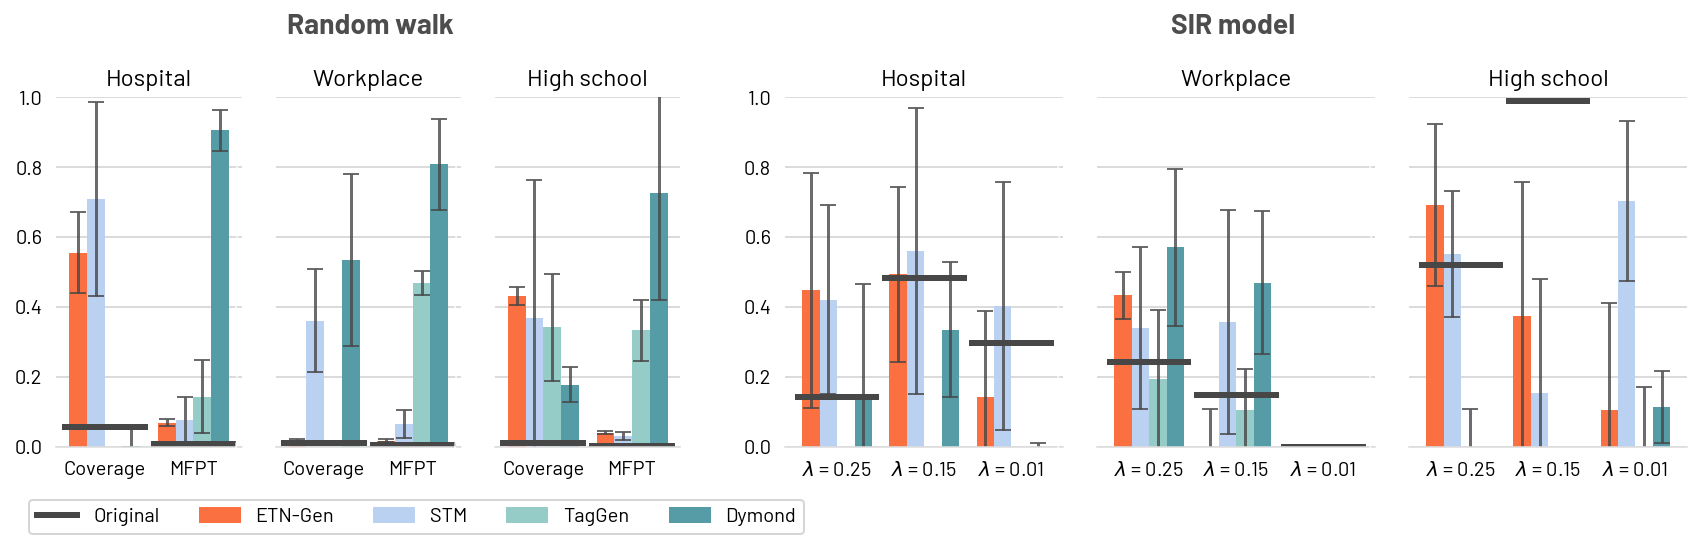

In [15]:
fig, ax = plt.subplots(1,7, figsize=(12,3), gridspec_kw={'width_ratios': [1,1,1,0.2,1.5,1.5,1.5]})
fig.tight_layout(w_pad=-1)


plot_cov_mfpt3(ax[0],"LH10")
plot_cov_mfpt3(ax[1],"InVS13")
plot_cov_mfpt3(ax[2],"High_School11",legend=True)

empty_plot(ax[3])

plot_r03(ax[4],"LH10")
plot_r03(ax[5],"InVS13")
plot_r03(ax[6],"High_School11",legend=True)


ax[1].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='y', colors='white')

#ax[4].tick_params(axis='y', colors='white')
ax[5].tick_params(axis='y', colors='white')
ax[6].tick_params(axis='y', colors='white')

legend_elements = [Line2D([0], [0], color=ORIGINAL_COLOR, lw=3,label='Original'),
                   Patch(facecolor=ETN_COLOR, edgecolor=ETN_COLOR,label='ETN-Gen'),
                   Patch(facecolor=STM_COLOR, edgecolor=STM_COLOR,label='STM'),
                   Patch(facecolor=TAG_COLOR, edgecolor=TAG_COLOR,label='TagGen'),
                   Patch(facecolor=DYM_COLOR, edgecolor=DYM_COLOR,label='Dymond')]

# Create the figure
ax[0].legend(handles=legend_elements,loc='center left', bbox_to_anchor=(-0.2, -0.2),ncol=5)

fig.text(0.17, 1.08, 'Random walk',fontdict={'size':14,'color':'#4d4d4d'},weight="bold")
fig.text(0.682, 1.08, 'SIR model',fontdict={'size':14,'color':'#4d4d4d'},weight="bold")


fig.savefig("dynamic_main_test_kld_test2.pdf", bbox_inches = 'tight')

In [25]:
ori,stab,etn,stm,tag,dym = load_r0("InVS13",lambds=["la001"])

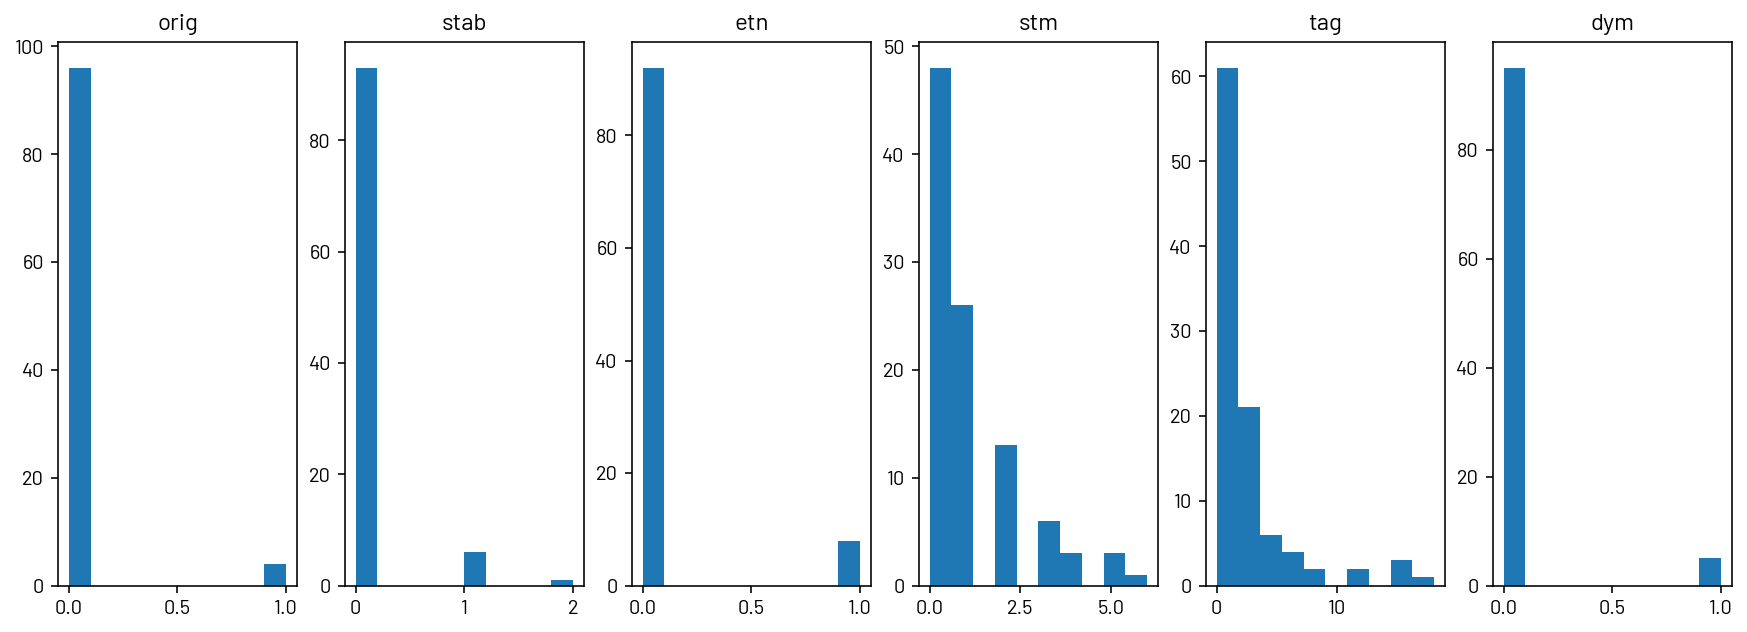

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,6,1)
plt.hist(ori)
plt.title("orig")
plt.subplot(1,6,2)
plt.hist(stab)
plt.title("stab")
plt.subplot(1,6,3)
plt.hist(etn[0][0])
plt.title("etn")
plt.subplot(1,6,4)
plt.hist(stm[0][0])
plt.title("stm")
plt.subplot(1,6,5)
plt.hist(tag[0][0])
plt.title("tag")
plt.subplot(1,6,6)
plt.hist(dym[0][0])
plt.title("dym")
plt.show()